Dask Approach to Non-SQL PTM Queries
--

* v01: move away from classes, try to organize the computation 
primarily in dask.
* v02: target optimization.
* v03: why not Bayesian?
* emcee_v01: refine Bayesian to use a counting distribution
* emcee_v02: include storm_factor

The observations are overdisperse, and a Poisson distribution did not
lead to convergence. A negative binomial was much better, with a dispersion
parameter $\alpha \approx 1.75$ performed well, with $\alpha$ determined
*a priori* by MLE. This was done in three steps:
1. Fit a negative binomial to the full set of observations, not conditioned
   on the model output. Though dependent on the handling of blank contamination,
   this yields $\alpha \approx 3.4$. Q-Q plots show that log-normal is very good
   when ignoring blank contamination, but negative binomial is better when 
   blank contamination is subtracted out. I did not re-attempt this process
   with the updated marginal likelihood code.
2. Fit model rates (decay, beaching, deposition) based on that $\alpha$, by
   maximum likelihood.
3. Use the result of 2 as a starting point to fit rates *and* $\alpha$, again
   use maximum likelihood.  This yields $\alpha \approx 1.73$.

The updated $\alpha$ was then kept constant for the MCMC sampling. The result
was

Accounting for blank contamination
--
When fitting a distribution to the overall set of observations, I originally
ignored blank contamination, and log-normal was the clear winner. Offsetting
the observations by a constant to account for blank contamination makes 
negative binomial closer, and log-normal becomes worse. This is in part because
we end up with some zero-inflation, those have to be clipped to >0 for log-normal,
and the fit deteriorates.

This leads to the question of how to properly implement the likelihood. I think 
what I want to say is:
$$
\begin{align}
 N_{i,true}  & \sim \textrm{NegBinom}( \mu=N_{i,model}, \alpha=\alpha_0 ) \\
 N_{i,blank} & \sim \textrm{Poisson}( \mu=\mu_{blank} ) \\
 N_{i,obs}   & = N_{i,true} + N_{i,blank}
\end{align}
$$

Attempting to parrot some notation from [https://krasserm.github.io/2019/11/21/latent-variable-models-part-1/](here)

$\mathbf{\theta}$ are my model parameters. In my case, 
$\mathbf{\theta} = \{k_{beach},k_{deposit},k_{decay}\}$.

The hydrodynamics, particle tracking, and source loading collectively define a forward model
$$
\mu_i = M(obs_i,\theta)
$$
where $i$ indexes observations, $\mu_i$ is the count predicted by the model, $obs_i$ encapsulates the observation metadata (time, location, trawl area).

Take $x_i$ to be the observed count. The first set of equations above can be rewritten in this likelihood form
as
$$
p(x_i|b_i,\theta) = \textrm{NB}\left(x_i-b_i | \mu_i,\alpha \right)
$$
where $b_i$ is the blank contamination for observation $i$. This is fine if we intend
to sample $b_i$. Based on the measurements of blank contamination, we have a
reasonable prior for $b_i$ as a sum of 5 Poisson distributions. 

But instead of sampling $b_i$, I want to marginalize it
$$
p(x_i|\theta) = \sum_{b_i\in \textit{N}} p(b_i) p(x_i|b_i,\theta)
$$

***I've lost my way.***




*Without* the blank issue, I have:
$$
LL_i = \textrm{NegBinom.logpmf}( N_{i,obs}, \mu=N_{i,model}, \alpha=\alpha_0)
$$
or in other words, use the negative binomial distribution with a mean predicted
by the model and evaluate it for the observed count.

I think that one option to include blanks is to explicitly integrate over the Poisson:
$$
LL_i = \log \left[ \sum_{b=b_{min}}^{b_{max}} 
                     \textrm{NegBinom.pmf}( N_{i,obs}-b, \mu=N_{i,model}, \alpha=\alpha_0)
                     \cdot
                     \textrm{Poisson.pmf}( b, \mu_{blank} ) 
           \right]
$$

The mean contamination is on the order of 4, so this integration could test for $b\in[0,15]$
and capture enough of the probability mass.

Accounting for catch efficiency
--
Simply including a global scale factor leads to confusion. The optimization
and mcmc sampling try to increase both the scale factor and the beaching rate.
Seems to be specific to beaching and scale. Deposition and decay are still 
distributed near 0. MAP puts beaching at 0.497 and scale at 2.1006. If instead
I set scale at 0.5, what beaching comes out? 0.10445.

Basic comparison of scatter plots for these two parameter sets is not illuminating.
Visually the scale=2, beaching=0.5 parameters do look a tiny bit cleaner.


What does this mean?
 * Current beaching approach is not sensitive enough.
 * Data are insufficient to fit both scale and beaching.

What to do?
 * Break samples out into morphologies, size groups, settling velocity classes. 
 * Set catch efficiency from literature?


Suggestions from Ed:
- Negative binomial or actually multinomial (to get, e.g., a size distribution)
- probably have to use a discrete distribution
- Laura Mitchell paper about how to deal with catchability of fish.

In [1]:
import postproc_dask as post
import six

In [2]:
import matplotlib.pyplot as plt
import conc_figure
import six
import stompy.plot.cmap as scmap
from stompy.spatial import proj_utils
from matplotlib import cm
cmap=cm.CMRmap_r
cmap=scmap.cmap_clip(cmap,0.03,1.0)

%matplotlib notebook

In [3]:
import itertools

In [4]:
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import re

from stompy.grid import unstructured_grid
from stompy import utils, memoize
from stompy.model.fish_ptm import ptm_config, ptm_tools
from stompy.model.suntans import sun_driver
from scipy.stats import spearmanr

import stompy.plot.cmap as scmap
from scipy import stats
import seaborn as sns
turbo=scmap.load_gradient('turbo.cpt')

Overall Process
===

1. SUNTANS hydro runs
2. SUNTANS average output
3. ptm-formatted average output
4. PTM runs
5. Load data

The top-level query is something like *generate a map of concentrations for...*

filter on:
 - sources $x$
 - settling classes $y$
 - vertical positions $z$
 - horizontal positions $h$

weighted by

 - loading data 
 - age
 
mapped by one of ...

 - bounding box
 - put on hydro grid
 - put on regular grid

and possibly smoothed.

In [6]:
# Experiment level configuration -- small, all python native data.
import cfg_v01 
cfg=cfg_v01.cfg

In [8]:
# This doesn't seem to work from within jupyter notebook.
# it allocates huge amounts of memory and gets stuck.
# import multiprocessing
compute_kw={} # dict(pool=multiprocessing.Pool(24))

In [ ]:
# So far this is only used locally.  Slow to compute (15s)
Msmooth=cfg.grid.smooth_matrix()

Msmooth_K=cfg.grid.smooth_matrix(K=100*np.ones(cfg.grid.Nedges()))

In [12]:
areas=cfg.grid.cells_area()    

In [13]:
os.makedirs(cfg['manta_out_dir'],exist_ok=True)

Next steps
--


1. Recreate some of the figures from before, including on-grid smoothing.  
  a. Sample plot: from the powerpoint. 2017-08-30 to 2017-09-14. Surface particles
     max age of 10 days.   *This plot is similarish -- not exactly the same but close
     enough to rule out fundamental errors*
2. Pull out manta samples as before. Maybe skip putting it on the grid, just
   query a radius.
  a. Implement in this notebook
  b. Move all of this to a module.

In [14]:
ll2utm=proj_utils.mapper('WGS84','EPSG:26910')
# Load the manta data, clean it up
manta_fn='manta_summary-v03.csv'
manta=pd.read_csv(manta_fn)
# manta.head()

In [15]:
blank_rates=pd.read_csv("blank_rates-v04.csv").set_index('cat')['blank_rate']

In [16]:
blank_rates

cat
Fiber           42.000
Fiber Bundle     1.875
Fragment         1.875
Foam             0.125
Film             0.000
Sphere           0.000
Name: blank_rate, dtype: float64

In [17]:
godwin_offset_h=post.godwin_offset_h
godwin=post.godwin

In [18]:
import numexpr as ne
ne.set_num_threads(16) # reasonable on cws-linuxmodeling

8

In [59]:
# Streamlined version that only allows 
# tau, shore_factor and bed_factor, storm_factor to change.
# Msmooth is already set.

# Precalculate:
if 1: 
    manta_chrono=manta.sort_values('DATE') # helps with locality during precalculation
    # storm_factor=1.0
    # here the v01 code uses storm_factor=0.326, to account for
    # the difference between 355um-only samples and all of the samples.
    # here we will want to keep storm_factor unspecified
    # This 0.326 adjustment for 355um vs all samples, though, is baked into preweighted.
    storm_adjust=0.326
    step=-10000
    precalc={} # idx => stuff.

    # Force mantas to be sorted, so that data from the same day
    # is grouped together.
    last_DATE=None
    df=None

    for idx,rec in utils.progress(manta_chrono.iterrows()):
        #print(idx)
        # since we're just pulling out whole days, cache by day.
        # and pull through the end of that day
        # 5s, all in read_parquet
        if rec.DATE==last_DATE:
            pass
        else:
            df=post.particles_for_date(rec.DATE,cfg=cfg,compute_kw=compute_kw)
            last_DATE=rec.DATE

        # Trawl-specific processing:
        # Pull subset of cells
        # add a cell weighting, and a time weighting for the tidal filter
        cells,weights=post.rec_to_cell_weights(rec,areas=areas,grid=cfg.grid,
                                               Msmooth=Msmooth,smooth=step,thresh=1e-5)
        df_spatial=pd.DataFrame(dict(cell=cells,weight_spatial=weights)).set_index('cell')
        df_spatial_sort=df_spatial.sort_index()
        space_cell=df_spatial_sort.index.values
        space_weight=df_spatial_sort['weight_spatial'].values
        df_cell=df.cell.values
        df_idx=np.searchsorted(space_cell,df_cell).clip(0,len(space_cell)-1)
        sel=space_cell[df_idx]==df_cell
        tdf=df[sel].copy()
        weight_spatial=space_weight[df_idx[sel]]

        t_sample=np.datetime64(rec['DATE'])    
        t_center = t_sample+np.timedelta64(8,'h') + np.timedelta64(12,'h')
        delta_hours=((tdf['time']-t_center)/np.timedelta64(1,'h')).astype(np.int32)
        weight_time=godwin[delta_hours+godwin_offset_h]
        age=tdf['time'].values - tdf['rel_time'].values

        age_s=(age/np.timedelta64(1,'s')).astype(np.float32)
        bed_hits=tdf['bed_hits'].values
        shore_hits=tdf['shore_hits'].values
        mp_per_area = (tdf['mp_per_particle'] / areas[tdf['cell']]).values

        # v02 difference:
        # 0: stormwater, 1:wastewater
        group=post.group_weights(tdf,0.0).astype(np.int8)
        # Omits decay, bed, shore weights - also v02 difference
        adjust=np.array([storm_adjust,1.0])[group]
        pre_weighted=weight_spatial*weight_time*mp_per_area*adjust
        
        # Final code below then needs age_s, bed_hits, shore_hits, and
        # with v02, group in {0,1}
        sel=pre_weighted>0.0
        
        bundle=np.zeros(sel.sum(),[('preweighted',np.float32),
                                   ('age_s',np.float32),
                                   ('bed_hits',np.int16),
                                   ('shore_hits',np.int16),
                                   ('group',np.int8)])
        bundle['preweighted']=pre_weighted[sel]
        bundle['age_s']=age_s[sel]
        bundle['bed_hits']=bed_hits[sel]
        bundle['shore_hits']=shore_hits[sel]
        bundle['group']=group[sel]
        
        print(f"Manta sample {idx}: {bundle.nbytes:.2e} bytes, {len(bundle):.2e} elements")
        
        # Can get maybe a factor of 3 by combining duplicates
        df_bundle=pd.DataFrame.from_records(bundle)
        uniquified=df_bundle.groupby(['age_s','bed_hits','shore_hits','group'])['preweighted'].sum().reset_index()
        bundle=np.zeros(len(uniquified),dtype=bundle.dtype)
        bundle['preweighted']=uniquified['preweighted']
        bundle['age_s']=uniquified['age_s']
        bundle['bed_hits']=uniquified['bed_hits']
        bundle['shore_hits']=uniquified['shore_hits']
        bundle['group']=uniquified['group']
        print(f"    uniquified: {bundle.nbytes:.2e} bytes, {len(bundle):.2e} elements")
        
        precalc[idx]=bundle

#                        weights=ne.evaluate('weight_spatial*weight_time*decay*group_weight*bed_weight*shore_weight')
#                        unweighted=mp_per_area
#                        final_weights=weights
#                        # final_concs=weights*mp_per_area
#                        C=ne.evaluate( 'sum(weights*mp_per_area)')

Manta sample 0: 4.73e+08 bytes, 3.64e+07 elements


INFO:utils:1


    uniquified: 1.77e+08 bytes, 1.36e+07 elements
Manta sample 1: 4.75e+08 bytes, 3.65e+07 elements


INFO:utils:2


    uniquified: 1.77e+08 bytes, 1.36e+07 elements
Manta sample 2: 4.60e+08 bytes, 3.54e+07 elements


INFO:utils:3


    uniquified: 1.73e+08 bytes, 1.33e+07 elements
Manta sample 3: 4.74e+08 bytes, 3.65e+07 elements


INFO:utils:4


    uniquified: 1.77e+08 bytes, 1.36e+07 elements
Manta sample 4: 4.40e+08 bytes, 3.38e+07 elements


INFO:utils:5


    uniquified: 1.69e+08 bytes, 1.30e+07 elements
Manta sample 5: 4.66e+08 bytes, 3.59e+07 elements


INFO:utils:6


    uniquified: 1.76e+08 bytes, 1.35e+07 elements
Manta sample 6: 4.63e+08 bytes, 3.56e+07 elements


INFO:utils:7


    uniquified: 1.75e+08 bytes, 1.35e+07 elements
Manta sample 7: 4.68e+08 bytes, 3.60e+07 elements


INFO:utils:8


    uniquified: 1.76e+08 bytes, 1.35e+07 elements
Manta sample 11: 3.82e+08 bytes, 2.94e+07 elements


INFO:utils:9


    uniquified: 1.56e+08 bytes, 1.20e+07 elements
Manta sample 10: 3.81e+08 bytes, 2.93e+07 elements


INFO:utils:10


    uniquified: 1.55e+08 bytes, 1.19e+07 elements
Manta sample 8: 3.78e+08 bytes, 2.91e+07 elements


INFO:utils:11


    uniquified: 1.54e+08 bytes, 1.19e+07 elements
Manta sample 9: 3.61e+08 bytes, 2.78e+07 elements


INFO:utils:12


    uniquified: 1.49e+08 bytes, 1.14e+07 elements
Manta sample 12: 3.19e+08 bytes, 2.45e+07 elements


INFO:utils:13


    uniquified: 1.37e+08 bytes, 1.05e+07 elements
Manta sample 13: 3.29e+08 bytes, 2.53e+07 elements


INFO:utils:14


    uniquified: 1.40e+08 bytes, 1.07e+07 elements
Manta sample 14: 2.39e+08 bytes, 1.84e+07 elements


INFO:utils:15


    uniquified: 1.08e+08 bytes, 8.31e+06 elements
Manta sample 15: 4.47e+08 bytes, 3.44e+07 elements


INFO:utils:16


    uniquified: 1.73e+08 bytes, 1.33e+07 elements
Manta sample 16: 4.47e+08 bytes, 3.44e+07 elements


INFO:utils:17


    uniquified: 1.73e+08 bytes, 1.33e+07 elements
Manta sample 17: 5.04e+08 bytes, 3.88e+07 elements


INFO:utils:18


    uniquified: 1.74e+08 bytes, 1.34e+07 elements
Manta sample 18: 4.74e+08 bytes, 3.65e+07 elements


INFO:utils:19


    uniquified: 1.66e+08 bytes, 1.28e+07 elements
Manta sample 19: 4.74e+08 bytes, 3.64e+07 elements


INFO:utils:20


    uniquified: 1.66e+08 bytes, 1.28e+07 elements
Manta sample 20: 4.74e+08 bytes, 3.65e+07 elements


INFO:utils:21


    uniquified: 1.66e+08 bytes, 1.28e+07 elements
Manta sample 21: 4.73e+08 bytes, 3.64e+07 elements


INFO:utils:22


    uniquified: 1.66e+08 bytes, 1.28e+07 elements
Manta sample 22: 4.05e+08 bytes, 3.12e+07 elements


INFO:utils:23


    uniquified: 1.53e+08 bytes, 1.17e+07 elements
Manta sample 23: 4.11e+08 bytes, 3.16e+07 elements


INFO:utils:24


    uniquified: 1.54e+08 bytes, 1.18e+07 elements
Manta sample 24: 4.43e+08 bytes, 3.41e+07 elements


INFO:utils:25


    uniquified: 1.62e+08 bytes, 1.25e+07 elements
Manta sample 25: 5.07e+08 bytes, 3.90e+07 elements


INFO:utils:26


    uniquified: 1.83e+08 bytes, 1.40e+07 elements
Manta sample 26: 3.43e+08 bytes, 2.64e+07 elements


INFO:utils:27


    uniquified: 1.48e+08 bytes, 1.14e+07 elements
Manta sample 27: 6.05e+08 bytes, 4.65e+07 elements


INFO:utils:28


    uniquified: 1.96e+08 bytes, 1.51e+07 elements
Manta sample 28: 5.42e+08 bytes, 4.17e+07 elements


INFO:utils:29


    uniquified: 1.75e+08 bytes, 1.35e+07 elements
Manta sample 29: 5.32e+08 bytes, 4.10e+07 elements


INFO:utils:30


    uniquified: 1.74e+08 bytes, 1.33e+07 elements
Manta sample 30: 3.29e+08 bytes, 2.53e+07 elements


INFO:utils:31


    uniquified: 1.05e+08 bytes, 8.09e+06 elements
Manta sample 31: 3.29e+08 bytes, 2.53e+07 elements


INFO:utils:32


    uniquified: 1.05e+08 bytes, 8.09e+06 elements
Manta sample 37: 6.69e+08 bytes, 5.15e+07 elements


INFO:utils:33


    uniquified: 1.66e+08 bytes, 1.28e+07 elements
Manta sample 36: 6.70e+08 bytes, 5.15e+07 elements


INFO:utils:34


    uniquified: 1.66e+08 bytes, 1.28e+07 elements
Manta sample 35: 6.70e+08 bytes, 5.15e+07 elements


INFO:utils:35


    uniquified: 1.66e+08 bytes, 1.28e+07 elements
Manta sample 32: 6.75e+08 bytes, 5.19e+07 elements


INFO:utils:36


    uniquified: 1.68e+08 bytes, 1.29e+07 elements
Manta sample 33: 6.76e+08 bytes, 5.20e+07 elements


INFO:utils:37


    uniquified: 1.69e+08 bytes, 1.30e+07 elements
Manta sample 34: 6.70e+08 bytes, 5.15e+07 elements


INFO:utils:38


    uniquified: 1.66e+08 bytes, 1.28e+07 elements
Manta sample 38: 5.52e+08 bytes, 4.24e+07 elements


INFO:utils:39


    uniquified: 1.49e+08 bytes, 1.14e+07 elements
Manta sample 39: 5.34e+08 bytes, 4.11e+07 elements


INFO:utils:40


    uniquified: 1.44e+08 bytes, 1.11e+07 elements
Manta sample 40: 5.46e+08 bytes, 4.20e+07 elements


INFO:utils:41


    uniquified: 1.47e+08 bytes, 1.13e+07 elements
Manta sample 41: 3.26e+08 bytes, 2.51e+07 elements


INFO:utils:42


    uniquified: 9.02e+07 bytes, 6.94e+06 elements
Manta sample 42: 3.22e+08 bytes, 2.48e+07 elements


INFO:utils:43


    uniquified: 8.98e+07 bytes, 6.91e+06 elements
Manta sample 43: 3.27e+08 bytes, 2.52e+07 elements


INFO:utils:44


    uniquified: 9.06e+07 bytes, 6.97e+06 elements
Manta sample 52: 2.35e+08 bytes, 1.81e+07 elements


INFO:utils:45


    uniquified: 6.77e+07 bytes, 5.21e+06 elements
Manta sample 51: 2.34e+08 bytes, 1.80e+07 elements


INFO:utils:46


    uniquified: 6.76e+07 bytes, 5.20e+06 elements
Manta sample 49: 1.71e+08 bytes, 1.31e+07 elements


INFO:utils:47


    uniquified: 5.45e+07 bytes, 4.19e+06 elements
Manta sample 50: 2.32e+08 bytes, 1.79e+07 elements


INFO:utils:48


    uniquified: 6.72e+07 bytes, 5.17e+06 elements
Manta sample 48: 5.14e+08 bytes, 3.95e+07 elements


INFO:utils:49


    uniquified: 1.31e+08 bytes, 1.01e+07 elements
Manta sample 46: 5.12e+08 bytes, 3.94e+07 elements


INFO:utils:50


    uniquified: 1.31e+08 bytes, 1.00e+07 elements
Manta sample 45: 5.03e+08 bytes, 3.87e+07 elements


INFO:utils:51


    uniquified: 1.29e+08 bytes, 9.95e+06 elements
Manta sample 44: 5.01e+08 bytes, 3.86e+07 elements


INFO:utils:52


    uniquified: 1.29e+08 bytes, 9.94e+06 elements
Manta sample 47: 5.13e+08 bytes, 3.95e+07 elements


INFO:utils:53


    uniquified: 1.31e+08 bytes, 1.00e+07 elements
Manta sample 55: 2.89e+08 bytes, 2.23e+07 elements


INFO:utils:54


    uniquified: 1.00e+08 bytes, 7.70e+06 elements
Manta sample 56: 2.92e+08 bytes, 2.25e+07 elements


INFO:utils:55


    uniquified: 1.01e+08 bytes, 7.75e+06 elements
Manta sample 53: 3.03e+08 bytes, 2.33e+07 elements


INFO:utils:56


    uniquified: 1.04e+08 bytes, 7.97e+06 elements
Manta sample 54: 2.96e+08 bytes, 2.27e+07 elements


INFO:utils:57


    uniquified: 1.02e+08 bytes, 7.83e+06 elements
Manta sample 57: 2.92e+08 bytes, 2.25e+07 elements


INFO:utils:58


    uniquified: 1.02e+08 bytes, 7.81e+06 elements
Manta sample 58: 2.80e+08 bytes, 2.16e+07 elements


INFO:utils:59


    uniquified: 9.86e+07 bytes, 7.59e+06 elements
Manta sample 59: 3.10e+08 bytes, 2.38e+07 elements


INFO:utils:60


    uniquified: 1.05e+08 bytes, 8.04e+06 elements
Manta sample 60: 3.40e+08 bytes, 2.61e+07 elements


INFO:utils:61


    uniquified: 1.13e+08 bytes, 8.72e+06 elements
Manta sample 61: 3.40e+08 bytes, 2.61e+07 elements


INFO:utils:62


    uniquified: 1.13e+08 bytes, 8.72e+06 elements
Manta sample 63: 2.52e+08 bytes, 1.94e+07 elements


INFO:utils:63


    uniquified: 9.31e+07 bytes, 7.16e+06 elements
Manta sample 62: 2.46e+08 bytes, 1.89e+07 elements


INFO:utils:64


    uniquified: 9.16e+07 bytes, 7.05e+06 elements
Manta sample 64: 2.78e+08 bytes, 2.14e+07 elements
    uniquified: 9.89e+07 bytes, 7.61e+06 elements


In [60]:
pred_type=np.float64

def predict_mantas_fast(decay_rate,beach_rate=1e-2,depo_rate=1e-2,storm_factor=1.0):
    # tau_d: e-folding decay time scale in days
    # shore_factors: particle weight derated by (1-shore_factor)**hits
    # bed_factors: particle weighte derated by (1-bed_factor)**hits
    # print(f"tau={decay_rate}  shore={beach_rate}  bed={depo_rate}")
    preds=[]

    for idx,rec in utils.progress(manta_chrono.iterrows()):
        # print(idx)
        bundle=precalc[idx]
        age_s=bundle['age_s']
        shore_hits=bundle['shore_hits']
        bed_hits=bundle['bed_hits']
        preweighted=bundle['preweighted']
        group_factor=np.where(bundle['group']==0,storm_factor,1.)
                                        
        pred=dict(idx=idx,storm_factor=storm_factor,decay_rate=decay_rate,
                  step=step,Msmooth_i=0,
                  beach_rate=beach_rate,depo_rate=depo_rate)
        pred['idx']=idx
    
        # All in one go was actually half as fast
        weight=ne.evaluate('''group_factor * exp( -age_s*decay_rate/86400. 
                                   -shore_hits*beach_rate 
                                   -bed_hits*depo_rate )''')
        C=ne.evaluate( 'sum(preweighted*weight)')
         
        pred['C_model']=C
        preds.append(pred)

    df_pred=pd.DataFrame(preds)
    df_pred['C_model']=df_pred['C_model'].astype(np.float64)
    manta_pred=df_pred.join(manta_chrono,on='idx')
    return manta_pred

In [61]:
%%time

result=predict_mantas_fast(decay_rate=0.01,beach_rate=0.2,depo_rate=0.001,storm_factor=1.0)


INFO:utils:63


CPU times: user 19.7 s, sys: 3.89 s, total: 23.6 s
Wall time: 5.16 s


In [62]:
resultB=predict_mantas_fast(decay_rate=0.01,beach_rate=0.2,depo_rate=0.001,storm_factor=0.1)

INFO:utils:64


In [63]:
# max difference of 9, corresponding well to a manta sample that is mostly
# stormwater. Good!
(result['C_model']/resultB['C_model']).max()

9.069374745063394

In [64]:
# ensure that observed values are positive.
obs=manta_chrono['part_per_m2_nofiber'].values
detect_limit=0.5*obs[obs>0].min()
observed=obs.clip(detect_limit)

In [65]:
from scipy import stats
import emcee

In [66]:
cats=['Fiber Bundle','Fragment','Foam', 'Film','Sphere']

<IPython.core.display.Javascript object>


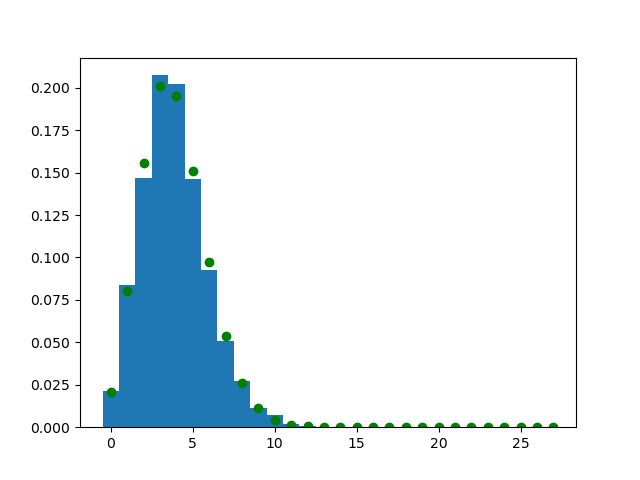

In [67]:
# Precalculate distribution for blanks
from functools import reduce

samps=np.arange(10)
dists=[stats.poisson.pmf(samps,blank_rates[cat]) for cat in cats]

blank_sum_dist=reduce(np.convolve,dists)
# Trim trailing zeros
last_nonzero=np.nonzero(blank_sum_dist)[0][-1]
blank_sum_dist=blank_sum_dist[:last_nonzero+1]

if 1: # "verify" distribution against sampling
    # First, the "empirical" distribution
    blanks=[np.sum( [stats.poisson.rvs(blank_rates[cat]) for cat in cats])
            for _ in range(5000)]
    plt.figure()
    # Very close. Not sure why the peak is slightly shifted.
    plt.hist(blanks,density=True,bins=np.arange(25)-0.5)
    plt.plot(blank_sum_dist,'go')

In [72]:
# The real setup
from scipy.special import logsumexp

# The baseline pieces include all possible variables,
# which are then specialized below.
full_dims=['beach','depo','decay','storm','scale','alpha']

def log_prior(beach,depo,decay,storm,scale,alpha):
    # just happens that at this point, non-negative is my only
    # constraint for all of the parameters
    if ( (beach<0)
         or (depo<0)
         or (decay<0)
         or (storm<0)
         or (scale<0)
         or (alpha<0) ):
        return -np.inf
    return 0  # flat prior for non-negative values

# theta is parameter vector.
ncalls=0
def log_likelihood(beach,depo,decay,storm,scale,alpha):
    global ncalls
    ncalls+=1
    LL=0.0

    df=predict_mantas_fast(beach_rate=beach,
                           depo_rate=depo,
                           decay_rate=decay,
                           storm_factor=storm)
    

    sigma=1.0 # log units
    LL=0
    
    for idx,rec in df.iterrows():
        o=rec['count_preblank_nofiber']
        m=scale * rec['C_model'] * rec['area_m2']
        
        if np.isinf(m):
            print("Model result was nan for ",theta)
            return -np.inf
        # convert to the parameters scipy wants
        mu=m
        sigma2=mu+alpha*mu**2
        p=mu/sigma2 
        n=1/alpha 
        if 1: # integration approach for blanks
            lls=[]
            for nblank,pm in enumerate(blank_sum_dist):
                if (pm>0.0) and (o-nblank)>=0:
                    lls.append( np.log(pm) + stats.nbinom.logpmf(o-nblank,n,p))
                else:
                    pass # probability=0
            ll=logsumexp(lls)

        LL+=ll
    return LL

# Original alpha=3.37 came from fitting NegativeBinomial to the full set of
# observations with some nominal blank subtraction.
# After finding some decent parameters with that alpha, a second optimization
# step (starting from the result of the first), additionally tuned alpha and
# finds alpha=1.75. That's now the default here.

def get_log_posterior(dims,defaults):
    # dims: list of parameter names
    # defaults: dict of default values for the rest of the parameters
    assert len(dims)+len(defaults)==len(full_dims)
    def log_posterior(theta,defaults=defaults,dims=dims):
        kwargs=dict(defaults) # copy it
        assert len(theta)==len(dims)
        for d,v in zip(dims,theta):
            kwargs[d]=v
        l=log_prior(**kwargs)
        if np.isfinite(l):
            l += log_likelihood(**kwargs)
        return l
    return log_posterior

In [77]:
from scipy.optimize import minimize

if 0:
    # Make sure we get the same result as in v01 - yep.
    dims=['beach','depo','decay']
    x0=[0.1,0.01,0.01]
    bnds=[(0,1),(0,1),(0,1)]
    log_posterior=get_log_posterior(dims, dict(alpha=1.75,storm=1,scale=1))
    # => [0.06046516, 0., 0.]
    # close enough to v01: [0.06046513, 0 , 0.] 
if 0:
    dims=['beach','depo','decay','storm']
    x0=[0.1,0.01,0.01,1.0]
    bnds=[(0,1),(0,1),(0,1),(0.01,5)]
    log_posterior=get_log_posterior(dims, dict(alpha=1.75,scale=1.0))
    # => [0.13089039, 0.        , 0.        , 2.69507553]
    # So even when scaling up only stormwater, it's still advantageous
    # to turn up beaching and loads.
if 1:
    dims=['beach','depo','decay','storm','scale']
    x0=[0.1,0.01,0.01,1.0,1.0]
    bnds=[(0,10),(0,1),(0,1),(0.01,20),(0.01,20)]
    log_posterior=get_log_posterior(dims, dict(alpha=1.75))
    # => [0.67647769, 0, 0, 2.56529601, 5.]
    # So it will happily crank up loads even more to allow cranking
    # up the beaching even more. Basically trying to make beaching
    # as strong as possible.
    # Raising bound on scale to 20: 
    # => [1., 0., 0., 3.16683761, 6.85953015]
    # It will keep going with this until the point that beaching is exhausted.
    # If we *did* have bed concentrations included, that would force
    # deposition to be nonzero. it might force storm and scale up even more,
    # so that beaching could be kept high.
    # Lifting the constraint on beaching rate:
    # [ 2.35795974,  0.        ,  0.        , 13.17029228,  9.43171849]
    # Bottom line is that MAP based only manta is not strong enough to 
    # overcome noise and model error.
    # 
    
def cb(xk):
    print("Iteration: ",xk)    
def cost(theta):
    lp=log_posterior(theta)
    print("log posterior %20f  for theta=%s"%(lp,theta))
    return (-lp).clip(-1000,20000)
result=minimize(cost,x0,bounds=bnds,
                callback=cb,options=dict(disp=True))


result.x 

INFO:utils:59


log posterior          -340.577521  for theta=[0.1  0.01 0.01 1.   1.  ]


INFO:utils:59


log posterior          -340.577523  for theta=[0.10000001 0.01       0.01       1.         1.        ]


INFO:utils:60


log posterior          -340.577523  for theta=[0.1        0.01000001 0.01       1.         1.        ]


INFO:utils:64


log posterior          -340.577523  for theta=[0.1        0.01       0.01000001 1.         1.        ]


INFO:utils:60


log posterior          -340.577521  for theta=[0.1        0.01       0.01       1.00000001 1.        ]


INFO:utils:61


log posterior          -340.577521  for theta=[0.1        0.01       0.01       1.         1.00000001]


INFO:utils:63


log posterior          -566.874162  for theta=[ 0.          0.          0.         19.73403915 20.        ]


INFO:utils:61


log posterior          -566.874109  for theta=[1.00000000e-08 0.00000000e+00 0.00000000e+00 1.97340391e+01
 2.00000000e+01]


INFO:utils:58


log posterior          -566.874154  for theta=[0.00000000e+00 1.00000000e-08 0.00000000e+00 1.97340391e+01
 2.00000000e+01]


INFO:utils:57


log posterior          -566.874154  for theta=[0.00000000e+00 0.00000000e+00 1.00000000e-08 1.97340391e+01
 2.00000000e+01]


INFO:utils:60


log posterior          -566.874162  for theta=[ 0.          0.          0.         19.73403916 20.        ]


INFO:utils:59


log posterior          -566.874162  for theta=[ 0.          0.          0.         19.73403915 19.99999999]


INFO:utils:57


log posterior          -404.456766  for theta=[0.07095633 0.00709563 0.00709563 6.44105291 6.5182977 ]


INFO:utils:61


log posterior          -404.456761  for theta=[0.07095634 0.00709563 0.00709563 6.44105291 6.5182977 ]


INFO:utils:59


log posterior          -404.456764  for theta=[0.07095633 0.00709564 0.00709563 6.44105291 6.5182977 ]


INFO:utils:59


log posterior          -404.456762  for theta=[0.07095633 0.00709563 0.00709564 6.44105291 6.5182977 ]


INFO:utils:59


log posterior          -404.456766  for theta=[0.07095633 0.00709563 0.00709563 6.44105292 6.5182977 ]


INFO:utils:58


log posterior          -404.456766  for theta=[0.07095633 0.00709563 0.00709563 6.44105291 6.51829771]


INFO:utils:58


log posterior          -343.541498  for theta=[0.0928463  0.00928463 0.00928463 2.34017648 2.35920252]


INFO:utils:57


log posterior          -343.541496  for theta=[0.09284631 0.00928463 0.00928463 2.34017648 2.35920252]


INFO:utils:60


log posterior          -343.541497  for theta=[0.0928463  0.00928464 0.00928463 2.34017648 2.35920252]


INFO:utils:57


log posterior          -343.541496  for theta=[0.0928463  0.00928463 0.00928464 2.34017648 2.35920252]


INFO:utils:60


log posterior          -343.541498  for theta=[0.0928463  0.00928463 0.00928463 2.34017649 2.35920252]


INFO:utils:59


log posterior          -343.541498  for theta=[0.0928463  0.00928463 0.00928463 2.34017648 2.35920253]


INFO:utils:60


log posterior          -333.079699  for theta=[0.09742788 0.00974279 0.00974279 1.48186116 1.48870198]


INFO:utils:61


log posterior          -333.079699  for theta=[0.09742789 0.00974279 0.00974279 1.48186116 1.48870198]


INFO:utils:59


log posterior          -333.079699  for theta=[0.09742788 0.0097428  0.00974279 1.48186116 1.48870198]


INFO:utils:60


log posterior          -333.079699  for theta=[0.09742788 0.00974279 0.0097428  1.48186116 1.48870198]


INFO:utils:61


log posterior          -333.079699  for theta=[0.09742788 0.00974279 0.00974279 1.48186117 1.48870198]


INFO:utils:62


log posterior          -333.079699  for theta=[0.09742788 0.00974279 0.00974279 1.48186116 1.48870199]
Iteration:  [0.09742788 0.00974279 0.00974279 1.48186116 1.48870198]


INFO:utils:61


log posterior          -332.839542  for theta=[0.10399626 0.00738609 0.00863579 1.47547124 1.48206875]


INFO:utils:58


log posterior          -332.839542  for theta=[0.10399627 0.00738609 0.00863579 1.47547124 1.48206875]


INFO:utils:59


log posterior          -332.839542  for theta=[0.10399626 0.0073861  0.00863579 1.47547124 1.48206875]


INFO:utils:60


log posterior          -332.839542  for theta=[0.10399626 0.00738609 0.0086358  1.47547124 1.48206875]


INFO:utils:62


log posterior          -332.839542  for theta=[0.10399626 0.00738609 0.00863579 1.47547125 1.48206875]


INFO:utils:63


log posterior          -332.839542  for theta=[0.10399626 0.00738609 0.00863579 1.47547124 1.48206876]
Iteration:  [0.10399626 0.00738609 0.00863579 1.47547124 1.48206875]


INFO:utils:63


log posterior          -332.116593  for theta=[1.24805227e-01 0.00000000e+00 1.41556196e-03 1.47201756e+00
 1.47800251e+00]


INFO:utils:62


log posterior          -332.116593  for theta=[1.24805237e-01 0.00000000e+00 1.41556196e-03 1.47201756e+00
 1.47800251e+00]


INFO:utils:59


log posterior          -332.116594  for theta=[1.24805227e-01 1.00000000e-08 1.41556196e-03 1.47201756e+00
 1.47800251e+00]


INFO:utils:59


log posterior          -332.116593  for theta=[1.24805227e-01 0.00000000e+00 1.41557196e-03 1.47201756e+00
 1.47800251e+00]


INFO:utils:60


log posterior          -332.116593  for theta=[1.24805227e-01 0.00000000e+00 1.41556196e-03 1.47201757e+00
 1.47800251e+00]


INFO:utils:60


log posterior          -332.116593  for theta=[1.24805227e-01 0.00000000e+00 1.41556196e-03 1.47201756e+00
 1.47800252e+00]
Iteration:  [1.24805227e-01 0.00000000e+00 1.41556196e-03 1.47201756e+00
 1.47800251e+00]


INFO:utils:60


log posterior          -332.004237  for theta=[0.13102617 0.         0.         1.49391519 1.50000839]


INFO:utils:58


log posterior          -332.004237  for theta=[0.13102618 0.         0.         1.49391519 1.50000839]


INFO:utils:60


log posterior          -332.004238  for theta=[1.31026170e-01 1.00000000e-08 0.00000000e+00 1.49391519e+00
 1.50000839e+00]


INFO:utils:59


log posterior          -332.004238  for theta=[1.31026170e-01 0.00000000e+00 1.00000000e-08 1.49391519e+00
 1.50000839e+00]


INFO:utils:59


log posterior          -332.004237  for theta=[0.13102617 0.         0.         1.4939152  1.50000839]


INFO:utils:58


log posterior          -332.004237  for theta=[0.13102617 0.         0.         1.49391519 1.5000084 ]
Iteration:  [0.13102617 0.         0.         1.49391519 1.50000839]


INFO:utils:62


log posterior          -331.860011  for theta=[0.14326896 0.         0.         1.56286323 1.56951547]


INFO:utils:60


log posterior          -331.860011  for theta=[0.14326897 0.         0.         1.56286323 1.56951547]


INFO:utils:61


log posterior          -331.860012  for theta=[1.43268959e-01 1.00000000e-08 0.00000000e+00 1.56286323e+00
 1.56951547e+00]


INFO:utils:64


log posterior          -331.860011  for theta=[1.43268959e-01 0.00000000e+00 1.00000000e-08 1.56286323e+00
 1.56951547e+00]


INFO:utils:62


log posterior          -331.860011  for theta=[0.14326896 0.         0.         1.56286324 1.56951547]


INFO:utils:62


log posterior          -331.860011  for theta=[0.14326896 0.         0.         1.56286323 1.56951548]
Iteration:  [0.14326896 0.         0.         1.56286323 1.56951547]


INFO:utils:61


log posterior          -331.461385  for theta=[0.20073065 0.         0.         1.90074443 1.91083427]


INFO:utils:62


log posterior          -331.461385  for theta=[0.20073066 0.         0.         1.90074443 1.91083427]


INFO:utils:64


log posterior          -331.461386  for theta=[2.00730654e-01 1.00000000e-08 0.00000000e+00 1.90074443e+00
 1.91083427e+00]


INFO:utils:64


log posterior          -331.461386  for theta=[2.00730654e-01 0.00000000e+00 1.00000000e-08 1.90074443e+00
 1.91083427e+00]


INFO:utils:64


log posterior          -331.461385  for theta=[0.20073065 0.         0.         1.90074444 1.91083427]


INFO:utils:64


log posterior          -331.461385  for theta=[0.20073065 0.         0.         1.90074443 1.91083428]
Iteration:  [0.20073065 0.         0.         1.90074443 1.91083427]


INFO:utils:63


log posterior          -331.380534  for theta=[0.23150212 0.         0.         2.07437706 2.08646852]


INFO:utils:63


log posterior          -331.380534  for theta=[0.23150213 0.         0.         2.07437706 2.08646852]


INFO:utils:63


log posterior          -331.380535  for theta=[2.31502124e-01 1.00000000e-08 0.00000000e+00 2.07437706e+00
 2.08646852e+00]


INFO:utils:62


log posterior          -331.380534  for theta=[2.31502124e-01 0.00000000e+00 1.00000000e-08 2.07437706e+00
 2.08646852e+00]


INFO:utils:61


log posterior          -331.380534  for theta=[0.23150212 0.         0.         2.07437707 2.08646852]


INFO:utils:60


log posterior          -331.380534  for theta=[0.23150212 0.         0.         2.07437706 2.08646853]
Iteration:  [0.23150212 0.         0.         2.07437706 2.08646852]


INFO:utils:64


log posterior          -331.349862  for theta=[0.25730935 0.         0.         2.21203706 2.22584924]


INFO:utils:64


log posterior          -331.349862  for theta=[0.25730936 0.         0.         2.21203706 2.22584924]


INFO:utils:64


log posterior          -331.349862  for theta=[2.57309346e-01 1.00000000e-08 0.00000000e+00 2.21203706e+00
 2.22584924e+00]


INFO:utils:63


log posterior          -331.349862  for theta=[2.57309346e-01 0.00000000e+00 1.00000000e-08 2.21203706e+00
 2.22584924e+00]
log posterior          -331.349862  for theta=[0.25730935 0.         0.         2.21203707 2.22584924]
log posterior          -331.349862  for theta=[0.25730935 0.         0.         2.21203706 2.22584925]
Iteration:  [0.25730935 0.         0.         2.21203706 2.22584924]


INFO:utils:62


log posterior          -331.338563  for theta=[0.27407616 0.         0.         2.2937362  2.30873829]


INFO:utils:62


log posterior          -331.338563  for theta=[0.27407617 0.         0.         2.2937362  2.30873829]


INFO:utils:63


log posterior          -331.338563  for theta=[2.74076163e-01 1.00000000e-08 0.00000000e+00 2.29373620e+00
 2.30873829e+00]


INFO:utils:60


log posterior          -331.338563  for theta=[2.74076163e-01 0.00000000e+00 1.00000000e-08 2.29373620e+00
 2.30873829e+00]


INFO:utils:63


log posterior          -331.338563  for theta=[0.27407616 0.         0.         2.29373621 2.30873829]


INFO:utils:63


log posterior          -331.338563  for theta=[0.27407616 0.         0.         2.2937362  2.3087383 ]
Iteration:  [0.27407616 0.         0.         2.2937362  2.30873829]


INFO:utils:63


log posterior          -331.330103  for theta=[0.28898748 0.         0.         2.35753257 2.3738334 ]


INFO:utils:64


log posterior          -331.330103  for theta=[0.28898749 0.         0.         2.35753257 2.3738334 ]


INFO:utils:62


log posterior          -331.330103  for theta=[2.88987479e-01 1.00000000e-08 0.00000000e+00 2.35753257e+00
 2.37383340e+00]


INFO:utils:60


log posterior          -331.330103  for theta=[2.88987479e-01 0.00000000e+00 1.00000000e-08 2.35753257e+00
 2.37383340e+00]


INFO:utils:59


log posterior          -331.330103  for theta=[0.28898748 0.         0.         2.35753258 2.3738334 ]


INFO:utils:60


log posterior          -331.330103  for theta=[0.28898748 0.         0.         2.35753257 2.37383341]
Iteration:  [0.28898748 0.         0.         2.35753257 2.3738334 ]


INFO:utils:58


log posterior          -331.324160  for theta=[0.30049641 0.         0.         2.39719868 2.41495116]


INFO:utils:58


log posterior          -331.324160  for theta=[0.30049642 0.         0.         2.39719868 2.41495116]


INFO:utils:59


log posterior          -331.324161  for theta=[3.00496414e-01 1.00000000e-08 0.00000000e+00 2.39719868e+00
 2.41495116e+00]


INFO:utils:60


log posterior          -331.324161  for theta=[3.00496414e-01 0.00000000e+00 1.00000000e-08 2.39719868e+00
 2.41495116e+00]


INFO:utils:60


log posterior          -331.324160  for theta=[0.30049641 0.         0.         2.39719869 2.41495116]


INFO:utils:60


log posterior          -331.324160  for theta=[0.30049641 0.         0.         2.39719868 2.41495117]
Iteration:  [0.30049641 0.         0.         2.39719868 2.41495116]


INFO:utils:60


log posterior          -331.322273  for theta=[0.3047105  0.         0.         2.4042764  2.42293156]


INFO:utils:60


log posterior          -331.322273  for theta=[0.30471051 0.         0.         2.4042764  2.42293156]


INFO:utils:59


log posterior          -331.322273  for theta=[3.04710502e-01 1.00000000e-08 0.00000000e+00 2.40427640e+00
 2.42293156e+00]


INFO:utils:62


log posterior          -331.322273  for theta=[3.04710502e-01 0.00000000e+00 1.00000000e-08 2.40427640e+00
 2.42293156e+00]


INFO:utils:63


log posterior          -331.322273  for theta=[0.3047105  0.         0.         2.40427641 2.42293156]


INFO:utils:63


log posterior          -331.322273  for theta=[0.3047105  0.         0.         2.4042764  2.42293157]
Iteration:  [0.3047105  0.         0.         2.4042764  2.42293156]


INFO:utils:57


log posterior          -331.322046  for theta=[0.30411753 0.         0.         2.39716713 2.4160423 ]


INFO:utils:59


log posterior          -331.322046  for theta=[0.30411754 0.         0.         2.39716713 2.4160423 ]


INFO:utils:59


log posterior          -331.322046  for theta=[3.04117532e-01 1.00000000e-08 0.00000000e+00 2.39716713e+00
 2.41604230e+00]


INFO:utils:60


log posterior          -331.322046  for theta=[3.04117532e-01 0.00000000e+00 1.00000000e-08 2.39716713e+00
 2.41604230e+00]


INFO:utils:59


log posterior          -331.322046  for theta=[0.30411753 0.         0.         2.39716714 2.4160423 ]


INFO:utils:60


log posterior          -331.322046  for theta=[0.30411753 0.         0.         2.39716713 2.41604231]
Iteration:  [0.30411753 0.         0.         2.39716713 2.4160423 ]


INFO:utils:59


log posterior          -331.321983  for theta=[0.30271502 0.         0.         2.38943196 2.40834614]


INFO:utils:60


log posterior          -331.321983  for theta=[0.30271503 0.         0.         2.38943196 2.40834614]


INFO:utils:58


log posterior          -331.321984  for theta=[3.02715024e-01 1.00000000e-08 0.00000000e+00 2.38943196e+00
 2.40834614e+00]


INFO:utils:60


log posterior          -331.321984  for theta=[3.02715024e-01 0.00000000e+00 1.00000000e-08 2.38943196e+00
 2.40834614e+00]


INFO:utils:61


log posterior          -331.321983  for theta=[0.30271502 0.         0.         2.38943197 2.40834614]


INFO:utils:59


log posterior          -331.321983  for theta=[0.30271502 0.         0.         2.38943196 2.40834615]
Iteration:  [0.30271502 0.         0.         2.38943196 2.40834614]


INFO:utils:59


log posterior          -331.321936  for theta=[0.30113614 0.         0.         2.38178524 2.4007617 ]


INFO:utils:59


log posterior          -331.321936  for theta=[0.30113615 0.         0.         2.38178524 2.4007617 ]


INFO:utils:59


log posterior          -331.321937  for theta=[3.01136138e-01 1.00000000e-08 0.00000000e+00 2.38178524e+00
 2.40076170e+00]


INFO:utils:60


log posterior          -331.321937  for theta=[3.01136138e-01 0.00000000e+00 1.00000000e-08 2.38178524e+00
 2.40076170e+00]


INFO:utils:57


log posterior          -331.321936  for theta=[0.30113614 0.         0.         2.38178525 2.4007617 ]


INFO:utils:57


log posterior          -331.321936  for theta=[0.30113614 0.         0.         2.38178524 2.40076171]
Iteration:  [0.30113614 0.         0.         2.38178524 2.4007617 ]


INFO:utils:60


log posterior          -331.321862  for theta=[0.29990778 0.         0.         2.37600194 2.39526306]


INFO:utils:64


log posterior          -331.321862  for theta=[0.29990779 0.         0.         2.37600194 2.39526306]


INFO:utils:64


log posterior          -331.321863  for theta=[2.99907784e-01 1.00000000e-08 0.00000000e+00 2.37600194e+00
 2.39526306e+00]
log posterior          -331.321862  for theta=[2.99907784e-01 0.00000000e+00 1.00000000e-08 2.37600194e+00
 2.39526306e+00]


INFO:utils:64


log posterior          -331.321862  for theta=[0.29990778 0.         0.         2.37600195 2.39526306]


INFO:utils:62


log posterior          -331.321862  for theta=[0.29990778 0.         0.         2.37600194 2.39526307]
Iteration:  [0.29990778 0.         0.         2.37600194 2.39526306]


INFO:utils:61


log posterior          -331.321511  for theta=[0.29666273 0.         0.         2.36019099 2.38133116]


INFO:utils:60


log posterior          -331.321511  for theta=[0.29666274 0.         0.         2.36019099 2.38133116]


INFO:utils:60


log posterior          -331.321512  for theta=[2.96662731e-01 1.00000000e-08 0.00000000e+00 2.36019099e+00
 2.38133116e+00]


INFO:utils:61


log posterior          -331.321511  for theta=[2.96662731e-01 0.00000000e+00 1.00000000e-08 2.36019099e+00
 2.38133116e+00]


INFO:utils:61


log posterior          -331.321511  for theta=[0.29666273 0.         0.         2.360191   2.38133116]


INFO:utils:60


log posterior          -331.321511  for theta=[0.29666273 0.         0.         2.36019099 2.38133117]
Iteration:  [0.29666273 0.         0.         2.36019099 2.38133116]


INFO:utils:60


log posterior          -331.320644  for theta=[0.29222477 0.         0.         2.33673874 2.36347254]


INFO:utils:60


log posterior          -331.320644  for theta=[0.29222478 0.         0.         2.33673874 2.36347254]


INFO:utils:60


log posterior          -331.320645  for theta=[2.92224773e-01 1.00000000e-08 0.00000000e+00 2.33673874e+00
 2.36347254e+00]


INFO:utils:61


log posterior          -331.320645  for theta=[2.92224773e-01 0.00000000e+00 1.00000000e-08 2.33673874e+00
 2.36347254e+00]


INFO:utils:61


log posterior          -331.320644  for theta=[0.29222477 0.         0.         2.33673875 2.36347254]


INFO:utils:63


log posterior          -331.320644  for theta=[0.29222477 0.         0.         2.33673874 2.36347255]
Iteration:  [0.29222477 0.         0.         2.33673874 2.36347254]


INFO:utils:63


log posterior          -331.318201  for theta=[0.28567924 0.         0.         2.2966212  2.34065047]


INFO:utils:62


log posterior          -331.318201  for theta=[0.28567925 0.         0.         2.2966212  2.34065047]


INFO:utils:57


log posterior          -331.318202  for theta=[2.85679245e-01 1.00000000e-08 0.00000000e+00 2.29662120e+00
 2.34065047e+00]


INFO:utils:59


log posterior          -331.318201  for theta=[2.85679245e-01 0.00000000e+00 1.00000000e-08 2.29662120e+00
 2.34065047e+00]


INFO:utils:56


log posterior          -331.318201  for theta=[0.28567924 0.         0.         2.29662121 2.34065047]


INFO:utils:58


log posterior          -331.318201  for theta=[0.28567924 0.         0.         2.2966212  2.34065048]
Iteration:  [0.28567924 0.         0.         2.2966212  2.34065047]


INFO:utils:56


log posterior          -331.311504  for theta=[0.27770471 0.         0.         2.23074945 2.32394004]


INFO:utils:56


log posterior          -331.311504  for theta=[0.27770472 0.         0.         2.23074945 2.32394004]


INFO:utils:62


log posterior          -331.311505  for theta=[2.77704708e-01 1.00000000e-08 0.00000000e+00 2.23074945e+00
 2.32394004e+00]


INFO:utils:62


log posterior          -331.311505  for theta=[2.77704708e-01 0.00000000e+00 1.00000000e-08 2.23074945e+00
 2.32394004e+00]


INFO:utils:62


log posterior          -331.311504  for theta=[0.27770471 0.         0.         2.23074946 2.32394004]


INFO:utils:62


log posterior          -331.311504  for theta=[0.27770471 0.         0.         2.23074945 2.32394005]
Iteration:  [0.27770471 0.         0.         2.23074945 2.32394004]


INFO:utils:62


log posterior          -331.292129  for theta=[0.27090884 0.         0.         2.11259609 2.35117183]


INFO:utils:63


log posterior          -331.292129  for theta=[0.27090885 0.         0.         2.11259609 2.35117183]


INFO:utils:62


log posterior          -331.292130  for theta=[2.70908837e-01 1.00000000e-08 0.00000000e+00 2.11259609e+00
 2.35117183e+00]


INFO:utils:64


log posterior          -331.292129  for theta=[2.70908837e-01 0.00000000e+00 1.00000000e-08 2.11259609e+00
 2.35117183e+00]


INFO:utils:62


log posterior          -331.292129  for theta=[0.27090884 0.         0.         2.1125961  2.35117183]


INFO:utils:63


log posterior          -331.292129  for theta=[0.27090884 0.         0.         2.11259609 2.35117184]
Iteration:  [0.27090884 0.         0.         2.11259609 2.35117183]


INFO:utils:63


log posterior          -331.243120  for theta=[0.27839    0.         0.         1.91525717 2.54678962]


INFO:utils:62


log posterior          -331.243120  for theta=[0.27839001 0.         0.         1.91525717 2.54678962]


INFO:utils:63


log posterior          -331.243121  for theta=[2.78390003e-01 1.00000000e-08 0.00000000e+00 1.91525717e+00
 2.54678962e+00]


INFO:utils:62


log posterior          -331.243121  for theta=[2.78390003e-01 0.00000000e+00 1.00000000e-08 1.91525717e+00
 2.54678962e+00]


INFO:utils:61


log posterior          -331.243120  for theta=[0.27839    0.         0.         1.91525718 2.54678962]


INFO:utils:63


log posterior          -331.243120  for theta=[0.27839    0.         0.         1.91525717 2.54678963]
Iteration:  [0.27839    0.         0.         1.91525717 2.54678962]


INFO:utils:63


log posterior          -331.164890  for theta=[0.32415436 0.         0.         1.74973152 3.05103021]


INFO:utils:60


log posterior          -331.164890  for theta=[0.32415437 0.         0.         1.74973152 3.05103021]


INFO:utils:63


log posterior          -331.164891  for theta=[3.24154358e-01 1.00000000e-08 0.00000000e+00 1.74973152e+00
 3.05103021e+00]


INFO:utils:62


log posterior          -331.164891  for theta=[3.24154358e-01 0.00000000e+00 1.00000000e-08 1.74973152e+00
 3.05103021e+00]


INFO:utils:62


log posterior          -331.164890  for theta=[0.32415436 0.         0.         1.74973153 3.05103021]


INFO:utils:60


log posterior          -331.164890  for theta=[0.32415436 0.         0.         1.74973152 3.05103022]
Iteration:  [0.32415436 0.         0.         1.74973152 3.05103021]


INFO:utils:58


log posterior          -331.020243  for theta=[0.4274831  0.         0.         1.78817315 3.91969366]


INFO:utils:62


log posterior          -331.020243  for theta=[0.42748311 0.         0.         1.78817315 3.91969366]


INFO:utils:62


log posterior          -331.020244  for theta=[4.27483102e-01 1.00000000e-08 0.00000000e+00 1.78817315e+00
 3.91969366e+00]


INFO:utils:63


log posterior          -331.020244  for theta=[4.27483102e-01 0.00000000e+00 1.00000000e-08 1.78817315e+00
 3.91969366e+00]


INFO:utils:63


log posterior          -331.020243  for theta=[0.4274831  0.         0.         1.78817316 3.91969366]


INFO:utils:62


log posterior          -331.020243  for theta=[0.4274831  0.         0.         1.78817315 3.91969367]
Iteration:  [0.4274831  0.         0.         1.78817315 3.91969366]


INFO:utils:62


log posterior          -330.728024  for theta=[0.74447333 0.         0.         2.15907877 6.38205238]


INFO:utils:62


log posterior          -330.728024  for theta=[0.74447334 0.         0.         2.15907877 6.38205238]


INFO:utils:63


log posterior          -330.728025  for theta=[7.44473325e-01 1.00000000e-08 0.00000000e+00 2.15907877e+00
 6.38205238e+00]


INFO:utils:61


log posterior          -330.728024  for theta=[7.44473325e-01 0.00000000e+00 1.00000000e-08 2.15907877e+00
 6.38205238e+00]


INFO:utils:62


log posterior          -330.728024  for theta=[0.74447333 0.         0.         2.15907878 6.38205238]


INFO:utils:63


log posterior          -330.728024  for theta=[0.74447333 0.         0.         2.15907877 6.38205239]
Iteration:  [0.74447333 0.         0.         2.15907877 6.38205238]


INFO:utils:62


log posterior          -330.681418  for theta=[0.9016832  0.         0.         2.41105762 7.54441999]


INFO:utils:61


log posterior          -330.681418  for theta=[0.90168321 0.         0.         2.41105762 7.54441999]


INFO:utils:62


log posterior          -330.681418  for theta=[9.01683196e-01 1.00000000e-08 0.00000000e+00 2.41105762e+00
 7.54441999e+00]


INFO:utils:63


log posterior          -330.681418  for theta=[9.01683196e-01 0.00000000e+00 1.00000000e-08 2.41105762e+00
 7.54441999e+00]


INFO:utils:63


log posterior          -330.681418  for theta=[0.9016832  0.         0.         2.41105763 7.54441999]


INFO:utils:62


log posterior          -330.681418  for theta=[0.9016832  0.         0.         2.41105762 7.54442   ]
Iteration:  [0.9016832  0.         0.         2.41105762 7.54441999]


INFO:utils:60


log posterior          -330.671458  for theta=[0.91963303 0.         0.         2.5227996  7.60666553]


INFO:utils:61


log posterior          -330.671458  for theta=[0.91963304 0.         0.         2.5227996  7.60666553]


INFO:utils:59


log posterior          -330.671459  for theta=[9.19633029e-01 1.00000000e-08 0.00000000e+00 2.52279960e+00
 7.60666553e+00]


INFO:utils:62


log posterior          -330.671458  for theta=[9.19633029e-01 0.00000000e+00 1.00000000e-08 2.52279960e+00
 7.60666553e+00]


INFO:utils:62


log posterior          -330.671458  for theta=[0.91963303 0.         0.         2.52279961 7.60666553]


INFO:utils:58


log posterior          -330.671458  for theta=[0.91963303 0.         0.         2.5227996  7.60666554]
Iteration:  [0.91963303 0.         0.         2.5227996  7.60666553]


INFO:utils:62


log posterior          -330.663438  for theta=[0.94351911 0.         0.         2.63828503 7.70505371]


INFO:utils:62


log posterior          -330.663438  for theta=[0.94351912 0.         0.         2.63828503 7.70505371]


INFO:utils:62


log posterior          -330.663439  for theta=[9.43519113e-01 1.00000000e-08 0.00000000e+00 2.63828503e+00
 7.70505371e+00]


INFO:utils:59


log posterior          -330.663438  for theta=[9.43519113e-01 0.00000000e+00 1.00000000e-08 2.63828503e+00
 7.70505371e+00]


INFO:utils:62


log posterior          -330.663438  for theta=[0.94351911 0.         0.         2.63828504 7.70505371]


INFO:utils:64


log posterior          -330.663438  for theta=[0.94351911 0.         0.         2.63828503 7.70505372]
Iteration:  [0.94351911 0.         0.         2.63828503 7.70505371]


INFO:utils:63


log posterior          -330.650943  for theta=[0.97814603 0.         0.         2.80123802 7.83227314]


INFO:utils:60


log posterior          -330.650943  for theta=[0.97814604 0.         0.         2.80123802 7.83227314]


INFO:utils:62


log posterior          -330.650944  for theta=[9.78146034e-01 1.00000000e-08 0.00000000e+00 2.80123802e+00
 7.83227314e+00]


INFO:utils:61


log posterior          -330.650943  for theta=[9.78146034e-01 0.00000000e+00 1.00000000e-08 2.80123802e+00
 7.83227314e+00]


INFO:utils:59


log posterior          -330.650943  for theta=[0.97814603 0.         0.         2.80123803 7.83227314]


INFO:utils:58


log posterior          -330.650943  for theta=[0.97814603 0.         0.         2.80123802 7.83227315]
Iteration:  [0.97814603 0.         0.         2.80123802 7.83227314]


INFO:utils:59


log posterior          -330.621513  for theta=[1.0495499  0.         0.         3.13769868 8.05736303]


INFO:utils:59


log posterior          -330.621513  for theta=[1.04954991 0.         0.         3.13769868 8.05736303]


INFO:utils:60


log posterior          -330.621514  for theta=[1.04954990e+00 1.00000000e-08 0.00000000e+00 3.13769868e+00
 8.05736303e+00]


INFO:utils:59


log posterior          -330.621513  for theta=[1.04954990e+00 0.00000000e+00 1.00000000e-08 3.13769868e+00
 8.05736303e+00]


INFO:utils:58


log posterior          -330.621513  for theta=[1.0495499  0.         0.         3.13769869 8.05736303]


INFO:utils:59


log posterior          -330.621513  for theta=[1.0495499  0.         0.         3.13769868 8.05736304]
Iteration:  [1.0495499  0.         0.         3.13769868 8.05736303]


INFO:utils:58


log posterior          -330.530516  for theta=[1.23818506 0.         0.         4.06075134 8.54702923]


INFO:utils:58


log posterior          -330.530516  for theta=[1.23818507 0.         0.         4.06075134 8.54702923]


INFO:utils:60


log posterior          -330.530516  for theta=[1.23818506e+00 1.00000000e-08 0.00000000e+00 4.06075134e+00
 8.54702923e+00]


INFO:utils:60


log posterior          -330.530516  for theta=[1.23818506e+00 0.00000000e+00 1.00000000e-08 4.06075134e+00
 8.54702923e+00]


INFO:utils:59


log posterior          -330.530516  for theta=[1.23818506 0.         0.         4.06075135 8.54702923]


INFO:utils:57


log posterior          -330.530516  for theta=[1.23818506 0.         0.         4.06075134 8.54702924]


INFO:utils:59


log posterior          -330.231154  for theta=[ 1.99272572  0.          0.          7.75296195 10.50569405]


INFO:utils:59


log posterior          -330.231154  for theta=[ 1.99272573  0.          0.          7.75296195 10.50569405]


INFO:utils:59


log posterior          -330.231154  for theta=[1.99272572e+00 1.00000000e-08 0.00000000e+00 7.75296195e+00
 1.05056940e+01]


INFO:utils:59


log posterior          -330.231154  for theta=[1.99272572e+00 0.00000000e+00 1.00000000e-08 7.75296195e+00
 1.05056940e+01]


INFO:utils:58


log posterior          -330.231154  for theta=[ 1.99272572  0.          0.          7.75296196 10.50569405]


INFO:utils:58


log posterior          -330.231154  for theta=[ 1.99272572  0.          0.          7.75296195 10.50569406]
Iteration:  [ 1.99272572  0.          0.          7.75296195 10.50569405]


INFO:utils:59


log posterior        -21312.637914  for theta=[9.45231356e+00 0.00000000e+00 0.00000000e+00 2.00000000e+01
 1.00000000e-02]


INFO:utils:57


log posterior        -21312.637916  for theta=[9.45231357e+00 0.00000000e+00 0.00000000e+00 2.00000000e+01
 1.00000000e-02]


INFO:utils:59


log posterior        -21312.638761  for theta=[9.45231356e+00 1.00000000e-08 0.00000000e+00 2.00000000e+01
 1.00000000e-02]


INFO:utils:58


log posterior        -21312.638347  for theta=[9.45231356e+00 0.00000000e+00 1.00000000e-08 2.00000000e+01
 1.00000000e-02]


INFO:utils:59


log posterior        -21312.637914  for theta=[9.45231356e+00 0.00000000e+00 0.00000000e+00 2.00000000e+01
 1.00000000e-02]


INFO:utils:59


log posterior        -21312.629680  for theta=[9.45231356e+00 0.00000000e+00 0.00000000e+00 2.00000000e+01
 1.00000100e-02]


INFO:utils:58


log posterior          -330.230400  for theta=[ 1.99332294  0.          0.          7.75394247 10.50485375]


INFO:utils:59


log posterior          -330.230400  for theta=[ 1.99332295  0.          0.          7.75394247 10.50485375]


INFO:utils:59


log posterior          -330.230401  for theta=[1.99332294e+00 1.00000000e-08 0.00000000e+00 7.75394247e+00
 1.05048537e+01]


INFO:utils:58


log posterior          -330.230400  for theta=[1.99332294e+00 0.00000000e+00 1.00000000e-08 7.75394247e+00
 1.05048537e+01]


INFO:utils:58


log posterior          -330.230400  for theta=[ 1.99332294  0.          0.          7.75394248 10.50485375]


INFO:utils:55


log posterior          -330.230400  for theta=[ 1.99332294  0.          0.          7.75394247 10.50485376]


INFO:utils:57


log posterior          -532.140478  for theta=[ 5.72281825  0.          0.         13.87697123  5.25742687]


INFO:utils:58


log posterior          -532.140479  for theta=[ 5.72281826  0.          0.         13.87697123  5.25742687]


INFO:utils:57


log posterior          -532.140618  for theta=[5.72281825e+00 1.00000000e-08 0.00000000e+00 1.38769712e+01
 5.25742687e+00]


INFO:utils:58


log posterior          -532.140499  for theta=[5.72281825e+00 0.00000000e+00 1.00000000e-08 1.38769712e+01
 5.25742687e+00]


INFO:utils:57


log posterior          -532.140478  for theta=[ 5.72281825  0.          0.         13.87697124  5.25742687]


INFO:utils:55


log posterior          -532.140478  for theta=[ 5.72281825  0.          0.         13.87697123  5.25742688]


INFO:utils:60


log posterior          -330.187045  for theta=[ 2.064106    0.          0.          7.87015302 10.40526147]


INFO:utils:59


log posterior          -330.187045  for theta=[ 2.06410601  0.          0.          7.87015302 10.40526147]


INFO:utils:58


log posterior          -330.187045  for theta=[2.06410600e+00 1.00000000e-08 0.00000000e+00 7.87015302e+00
 1.04052615e+01]


INFO:utils:58


log posterior          -330.187045  for theta=[2.06410600e+00 0.00000000e+00 1.00000000e-08 7.87015302e+00
 1.04052615e+01]


INFO:utils:58


log posterior          -330.187045  for theta=[ 2.064106    0.          0.          7.87015303 10.40526147]


INFO:utils:57


log posterior          -330.187045  for theta=[ 2.064106    0.          0.          7.87015302 10.40526148]
Iteration:  [ 2.064106    0.          0.          7.87015302 10.40526147]


INFO:utils:62


log posterior          -330.118233  for theta=[1.78569053 0.         0.         7.00836656 8.672821  ]


INFO:utils:61


log posterior          -330.118233  for theta=[1.78569054 0.         0.         7.00836656 8.672821  ]


INFO:utils:58


log posterior          -330.118234  for theta=[1.78569053e+00 1.00000000e-08 0.00000000e+00 7.00836656e+00
 8.67282100e+00]


INFO:utils:59


log posterior          -330.118233  for theta=[1.78569053e+00 0.00000000e+00 1.00000000e-08 7.00836656e+00
 8.67282100e+00]


INFO:utils:58


log posterior          -330.118233  for theta=[1.78569053 0.         0.         7.00836657 8.672821  ]


INFO:utils:58


log posterior          -330.118233  for theta=[1.78569053 0.         0.         7.00836656 8.67282101]
Iteration:  [1.78569053 0.         0.         7.00836656 8.672821  ]


INFO:utils:54


log posterior          -330.073782  for theta=[1.99096354 0.         0.         8.65267392 9.23840437]


INFO:utils:57


log posterior          -330.073782  for theta=[1.99096355 0.         0.         8.65267392 9.23840437]


INFO:utils:56


log posterior          -330.073783  for theta=[1.99096354e+00 1.00000000e-08 0.00000000e+00 8.65267392e+00
 9.23840437e+00]


INFO:utils:55


log posterior          -330.073782  for theta=[1.99096354e+00 0.00000000e+00 1.00000000e-08 8.65267392e+00
 9.23840437e+00]


INFO:utils:58


log posterior          -330.073782  for theta=[1.99096354 0.         0.         8.65267393 9.23840437]


INFO:utils:58


log posterior          -330.073782  for theta=[1.99096354 0.         0.         8.65267392 9.23840438]
Iteration:  [1.99096354 0.         0.         8.65267392 9.23840437]


INFO:utils:58


log posterior          -330.061775  for theta=[2.11793972 0.         0.         9.8437103  9.3152141 ]


INFO:utils:59


log posterior          -330.061775  for theta=[2.11793973 0.         0.         9.8437103  9.3152141 ]


INFO:utils:58


log posterior          -330.061775  for theta=[2.11793972e+00 1.00000000e-08 0.00000000e+00 9.84371030e+00
 9.31521410e+00]


INFO:utils:58


log posterior          -330.061775  for theta=[2.11793972e+00 0.00000000e+00 1.00000000e-08 9.84371030e+00
 9.31521410e+00]


INFO:utils:59


log posterior          -330.061775  for theta=[2.11793972 0.         0.         9.84371031 9.3152141 ]


INFO:utils:59


log posterior          -330.061775  for theta=[2.11793972 0.         0.         9.8437103  9.31521411]
Iteration:  [2.11793972 0.         0.         9.8437103  9.3152141 ]


INFO:utils:59


log posterior          -330.055297  for theta=[ 2.18685452  0.          0.         10.75451199  9.29289621]


INFO:utils:60


log posterior          -330.055297  for theta=[ 2.18685453  0.          0.         10.75451199  9.29289621]


INFO:utils:58


log posterior          -330.055297  for theta=[2.18685452e+00 1.00000000e-08 0.00000000e+00 1.07545120e+01
 9.29289621e+00]


INFO:utils:59


log posterior          -330.055297  for theta=[2.18685452e+00 0.00000000e+00 1.00000000e-08 1.07545120e+01
 9.29289621e+00]


INFO:utils:59


log posterior          -330.055297  for theta=[ 2.18685452  0.          0.         10.754512    9.29289621]


INFO:utils:58


log posterior          -330.055297  for theta=[ 2.18685452  0.          0.         10.75451199  9.29289622]
Iteration:  [ 2.18685452  0.          0.         10.75451199  9.29289621]


INFO:utils:57


log posterior          -330.050978  for theta=[ 2.23607582  0.          0.         11.49755885  9.31105391]


INFO:utils:59


log posterior          -330.050978  for theta=[ 2.23607583  0.          0.         11.49755885  9.31105391]


INFO:utils:59


log posterior          -330.050978  for theta=[2.23607582e+00 1.00000000e-08 0.00000000e+00 1.14975588e+01
 9.31105391e+00]


INFO:utils:57


log posterior          -330.050978  for theta=[2.23607582e+00 0.00000000e+00 1.00000000e-08 1.14975588e+01
 9.31105391e+00]


INFO:utils:58


log posterior          -330.050978  for theta=[ 2.23607582  0.          0.         11.49755886  9.31105391]


INFO:utils:63


log posterior          -330.050978  for theta=[ 2.23607582  0.          0.         11.49755885  9.31105392]
Iteration:  [ 2.23607582  0.          0.         11.49755885  9.31105391]


INFO:utils:60


log posterior          -330.048955  for theta=[ 2.30419057  0.          0.         12.34077464  9.39593819]


INFO:utils:63


log posterior          -330.048955  for theta=[ 2.30419058  0.          0.         12.34077464  9.39593819]


INFO:utils:62


log posterior          -330.048956  for theta=[2.30419057e+00 1.00000000e-08 0.00000000e+00 1.23407746e+01
 9.39593819e+00]


INFO:utils:59


log posterior          -330.048956  for theta=[2.30419057e+00 0.00000000e+00 1.00000000e-08 1.23407746e+01
 9.39593819e+00]


INFO:utils:60


log posterior          -330.048955  for theta=[ 2.30419057  0.          0.         12.34077465  9.39593819]


INFO:utils:62


log posterior          -330.048955  for theta=[ 2.30419057  0.          0.         12.34077464  9.3959382 ]
Iteration:  [ 2.30419057  0.          0.         12.34077464  9.39593819]


INFO:utils:62


log posterior          -330.048311  for theta=[ 2.33046462  0.          0.         12.7841665   9.41584939]


INFO:utils:61


log posterior          -330.048311  for theta=[ 2.33046463  0.          0.         12.7841665   9.41584939]


INFO:utils:57


log posterior          -330.048312  for theta=[2.33046462e+00 1.00000000e-08 0.00000000e+00 1.27841665e+01
 9.41584939e+00]


INFO:utils:59


log posterior          -330.048312  for theta=[2.33046462e+00 0.00000000e+00 1.00000000e-08 1.27841665e+01
 9.41584939e+00]


INFO:utils:57


log posterior          -330.048311  for theta=[ 2.33046462  0.          0.         12.78416651  9.41584939]


INFO:utils:59


log posterior          -330.048311  for theta=[ 2.33046462  0.          0.         12.7841665   9.4158494 ]
Iteration:  [ 2.33046462  0.          0.         12.7841665   9.41584939]


INFO:utils:59


log posterior          -330.048208  for theta=[ 2.35982883  0.          0.         13.1705785   9.4377745 ]


INFO:utils:58


log posterior          -330.048208  for theta=[ 2.35982884  0.          0.         13.1705785   9.4377745 ]


INFO:utils:56


log posterior          -330.048209  for theta=[2.35982883e+00 1.00000000e-08 0.00000000e+00 1.31705785e+01
 9.43777450e+00]


INFO:utils:57


log posterior          -330.048209  for theta=[2.35982883e+00 0.00000000e+00 1.00000000e-08 1.31705785e+01
 9.43777450e+00]


INFO:utils:59


log posterior          -330.048208  for theta=[ 2.35982883  0.          0.         13.17057851  9.4377745 ]


INFO:utils:55


log posterior          -330.048208  for theta=[ 2.35982883  0.          0.         13.1705785   9.43777451]
Iteration:  [ 2.35982883  0.          0.         13.1705785   9.4377745 ]


INFO:utils:60


log posterior          -330.048195  for theta=[ 2.3583682   0.          0.         13.17487635  9.43226236]


INFO:utils:59


log posterior          -330.048195  for theta=[ 2.35836821  0.          0.         13.17487635  9.43226236]


INFO:utils:56


log posterior          -330.048195  for theta=[2.35836820e+00 1.00000000e-08 0.00000000e+00 1.31748764e+01
 9.43226236e+00]


INFO:utils:56


log posterior          -330.048195  for theta=[2.35836820e+00 0.00000000e+00 1.00000000e-08 1.31748764e+01
 9.43226236e+00]


INFO:utils:56


log posterior          -330.048195  for theta=[ 2.3583682   0.          0.         13.17487636  9.43226236]


INFO:utils:53


log posterior          -330.048195  for theta=[ 2.3583682   0.          0.         13.17487635  9.43226237]
Iteration:  [ 2.3583682   0.          0.         13.17487635  9.43226236]


INFO:utils:59


log posterior          -330.048195  for theta=[ 2.35731963  0.          0.         13.16310851  9.43086618]


INFO:utils:57


log posterior          -330.048195  for theta=[ 2.35731964  0.          0.         13.16310851  9.43086618]


INFO:utils:57


log posterior          -330.048195  for theta=[2.35731963e+00 1.00000000e-08 0.00000000e+00 1.31631085e+01
 9.43086618e+00]


INFO:utils:57


log posterior          -330.048195  for theta=[2.35731963e+00 0.00000000e+00 1.00000000e-08 1.31631085e+01
 9.43086618e+00]


INFO:utils:57


log posterior          -330.048195  for theta=[ 2.35731963  0.          0.         13.16310852  9.43086618]


INFO:utils:59


log posterior          -330.048195  for theta=[ 2.35731963  0.          0.         13.16310851  9.43086619]


INFO:utils:58


log posterior          -330.048195  for theta=[ 2.35795974  0.          0.         13.17029228  9.43171849]


INFO:utils:59


log posterior          -330.048195  for theta=[ 2.35795975  0.          0.         13.17029228  9.43171849]


INFO:utils:58


log posterior          -330.048195  for theta=[2.35795974e+00 1.00000000e-08 0.00000000e+00 1.31702923e+01
 9.43171849e+00]


INFO:utils:60


log posterior          -330.048195  for theta=[2.35795974e+00 0.00000000e+00 1.00000000e-08 1.31702923e+01
 9.43171849e+00]


INFO:utils:60


log posterior          -330.048195  for theta=[ 2.35795974  0.          0.         13.17029229  9.43171849]


INFO:utils:62


log posterior          -330.048195  for theta=[ 2.35795974  0.          0.         13.17029228  9.4317185 ]
Iteration:  [ 2.35795974  0.          0.         13.17029228  9.43171849]


array([ 2.35795974,  0.        ,  0.        , 13.17029228,  9.43171849])

In [71]:
# comparing forward model between v01 and v02
# They now match!
df_test=predict_mantas_fast(decay_rate=0.0,beach_rate=0.05,depo_rate=0.0,storm_factor=1.0)
df_test.head()

INFO:utils:63


,idx,storm_factor,decay_rate,step,Msmooth_i,beach_rate,depo_rate,C_model,SampleID,SAMPLE LOCATION,...,part_per_m3_std,part_per_m2_std,part_per_m3_raw_std,part_per_m2_raw_std,part_per_m3_nofiber,part_per_m2_nofiber,part_per_m3_raw_nofiber,part_per_m2_raw_nofiber,x,y
0,0,1.0,0.0,-10000,0,0.05,0.0,0.017899,CB-4-Manta-21Aug2017,CB4,...,0.224191,0.021298,0.442172,0.042006,0.015526,0.001475,0.024841,0.002360,550040.331073,4.198063e+06
1,1,1.0,0.0,-10000,0,0.05,0.0,0.010077,SPB3-Manta-21Aug2017,SPB3,...,1.817781,0.172689,1.928407,0.183199,0.296678,0.028184,0.301706,0.028662,557329.971756,4.209634e+06
2,2,1.0,0.0,-10000,0,0.05,0.0,0.011864,SUB1-Manta-21Aug2017,SUB1,...,NaN,NaN,0.000000,0.000000,0.032671,0.003104,0.039205,0.003724,582363.556136,4.217527e+06
3,3,1.0,0.0,-10000,0,0.05,0.0,0.007506,SPB2-Manta-21Aug2017,SPB2,...,0.210549,0.020002,0.402882,0.038274,0.021966,0.002087,0.034288,0.003257,550464.046320,4.210092e+06
4,4,1.0,0.0,-10000,0,0.05,0.0,0.016433,CB9-Manta-22Aug2017,CB9,...,0.085947,0.008165,0.174186,0.016548,0.085947,0.008165,0.091677,0.008709,562183.425087,4.171973e+06


In [348]:
nwalkers = 6  # number of MCMC walkers
nburn = 2000  # "burn-in" period to let chains stabilize
nsteps = 4000  # number of MCMC steps to take

# with sigma=1.0, needed 2000+2000 to converge.
# How many calls?? 24k
# = 6 * 4000 

starting_guesses = np.random.rand(nwalkers, ndim)
# we'll start at random locations between 0 and 0.5
starting_guesses[:,0] *= 0.5 # beach rate [0,0.5]
starting_guesses[:,1] *= 0.1 # depo rate [0,0.1]
starting_guesses[:,2] *= 0.1 # decay rate [0,0.1]

back=emcee.backends.HDFBackend("samples-emcee-v02-nbinom_alpha1.75.h5")

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior,args=[],
                               backend=back)

sampler.run_mcmc(starting_guesses, nsteps,progress=True)

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :]  # discard burn-in points

100%|██████████| 4000/4000 [13:48:48<00:00, 12.43s/it]  


In [344]:
theta=[0.229,0,0]
# Not bad -- suggests alpha~1.80
for alpha in [1,1.2,1.4,1.6,1.8,2,2.2,2.5,2.8,2.9,3.0,3.1,3.2,3.3,3.4]:
    # Knowing that alpha was fit across samples that had a lot of modeled
    # variance in addition to unmodeled variance, explore smaller alpha
    lp=log_posterior(theta,alpha=alpha)
    print(f"alpha={alpha:5.2f}  lp={lp:.6f}")

alpha= 1.00  lp=-337.495248
alpha= 1.20  lp=-334.043099
alpha= 1.40  lp=-332.278827
alpha= 1.60  lp=-331.515305
alpha= 1.80  lp=-331.377828
alpha= 2.00  lp=-331.646959
alpha= 2.20  lp=-332.187077
alpha= 2.50  lp=-333.322451
alpha= 2.80  lp=-334.694309
alpha= 2.90  lp=-335.184557
alpha= 3.00  lp=-335.686421
alpha= 3.10  lp=-336.197642
alpha= 3.20  lp=-336.716303
alpha= 3.30  lp=-337.240769
alpha= 3.40  lp=-337.769643


In [345]:
# Start with the result of that optimization, but now also tune alpha.
x0=[0.1,0.01,0.01,1.8]
def cb(xk):
    print("Iteration: ",xk)
def cost(theta):
    theta,alpha=theta[:-1],theta[-1]
    lp=log_posterior(theta,alpha=alpha)
    print("log posterior %20f  for theta=%s alpha=%.4f"%(lp,theta,alpha))
    return (-lp).clip(-1000,20000)
result=minimize(cost,x0,bounds=[(0,1),(0,1),(0,1),(1,3.4)],
                callback=cb,options=dict(disp=True))
result.x # [0.22875575, 0.        , 0.        , 1.75525524]

log posterior          -336.609574  for theta=[0.1  0.01 0.01] alpha=1.8000
log posterior          -336.609572  for theta=[0.10000001 0.01       0.01      ] alpha=1.8000
log posterior          -336.609573  for theta=[0.1        0.01000001 0.01      ] alpha=1.8000
log posterior          -336.609573  for theta=[0.1        0.01       0.01000001] alpha=1.8000
log posterior          -336.609573  for theta=[0.1  0.01 0.01] alpha=1.8000
log posterior          -611.904095  for theta=[1. 1. 1.] alpha=3.4000
log posterior          -611.904093  for theta=[0.99999999 1.         1.        ] alpha=3.4000
log posterior          -611.904094  for theta=[1.         0.99999999 1.        ] alpha=3.4000
log posterior          -611.904093  for theta=[1.         1.         0.99999999] alpha=3.4000
log posterior          -611.904096  for theta=[1. 1. 1.] alpha=3.4000
log posterior          -348.667362  for theta=[0.22339328 0.1457326  0.1457326 ] alpha=2.0194
log posterior          -348.667363  for theta=[0.2

log posterior          -331.382112  for theta=[0.23274095 0.         0.        ] alpha=1.8000
Iteration:  [0.23274095 0.         0.         1.80001996]
log posterior          -331.374451  for theta=[0.23306315 0.         0.        ] alpha=1.7758
log posterior          -331.374451  for theta=[0.23306316 0.         0.        ] alpha=1.7758
log posterior          -331.374452  for theta=[2.3306315e-01 1.0000000e-08 0.0000000e+00] alpha=1.7758
log posterior          -331.374451  for theta=[2.3306315e-01 0.0000000e+00 1.0000000e-08] alpha=1.7758
log posterior          -331.374451  for theta=[0.23306315 0.         0.        ] alpha=1.7758
Iteration:  [0.23306315 0.         0.         1.77578522]
log posterior          -331.368800  for theta=[0.23121591 0.         0.        ] alpha=1.7560
log posterior          -331.368800  for theta=[0.23121592 0.         0.        ] alpha=1.7560
log posterior          -331.368801  for theta=[2.31215908e-01 1.00000000e-08 0.00000000e+00] alpha=1.7560
log post

array([0.22875575, 0.        , 0.        , 1.75525524])

In [391]:
# Extend one more time to get a global scaling, as an initial
# test of fitting catch efficiency.
# First go that tries to bump scale *up* and offset it
# with more beaching.
# Try again with a more generous upper bound on scale,
# and drop the decay and depo terms which seem not to matter
x0=[0.2,1.0]
def cb(xk):
    print("Iteration: ",xk)
def cost(theta):
    #beach,depo,decay,alpha,scale=theta
    beach,scale=theta
    depo=0 ; decay=0 ; alpha=1.75
    lp=log_posterior([beach,depo,decay,scale],alpha=alpha)
    print("log posterior %20f  for theta=%s alpha=%.4f scale=%.3f"%(lp,theta,alpha,scale))
    return np.clip(-lp,-1000,20000)
result=minimize(cost,x0,bounds=[(0,1),(0.01,10.0)],
                callback=cb,options=dict(disp=True))
result.x

log posterior          -331.616619  for theta=[0.2 1. ] alpha=1.7500 scale=1.000
log posterior          -331.616618  for theta=[0.20000001 1.        ] alpha=1.7500 scale=1.000
log posterior          -331.616619  for theta=[0.2        1.00000001] alpha=1.7500 scale=1.000
log posterior         -5809.591233  for theta=[1.   0.01] alpha=1.7500 scale=0.010
log posterior         -5809.591190  for theta=[0.99999999 0.01      ] alpha=1.7500 scale=0.010
log posterior         -5809.587567  for theta=[1.         0.01000001] alpha=1.7500 scale=0.010
log posterior          -357.981151  for theta=[0.46317648 0.6743191 ] alpha=1.7500 scale=0.674
log posterior          -357.981152  for theta=[0.46317649 0.6743191 ] alpha=1.7500 scale=0.674
log posterior          -357.981150  for theta=[0.46317648 0.67431911] alpha=1.7500 scale=0.674
log posterior          -331.409559  for theta=[0.22367498 0.97070221] alpha=1.7500 scale=0.971
log posterior          -331.409559  for theta=[0.22367499 0.97070221] alpha=

array([0.49704642, 2.10064182])

In [392]:
# Now force scale to something I like, and see what beaching comes
# out,then we'll plot how things vary betwen these two.
x0=[0.2]
def cb(xk):
    print("Iteration: ",xk)
def cost(theta):
    #beach,depo,decay,alpha,scale=theta
    beach=theta[0]
    scale=0.5
    depo=0 ; decay=0 ; alpha=1.75
    lp=log_posterior([beach,depo,decay,scale],alpha=alpha)
    print("log posterior %20f  for theta=%s alpha=%.4f scale=%.3f"%(lp,theta,alpha,scale))
    return np.clip(-lp,-1000,20000)
result=minimize(cost,x0,bounds=[(0,1)],
                callback=cb,options=dict(disp=True))
result.x

log posterior          -339.320886  for theta=[0.2] alpha=1.7500 scale=0.500
log posterior          -339.320887  for theta=[0.20000001] alpha=1.7500 scale=0.500
log posterior          -377.514246  for theta=[0.] alpha=1.7500 scale=0.500
log posterior          -377.514206  for theta=[1.e-08] alpha=1.7500 scale=0.500
log posterior          -332.990573  for theta=[0.1188777] alpha=1.7500 scale=0.500
log posterior          -332.990574  for theta=[0.11887771] alpha=1.7500 scale=0.500
Iteration:  [0.1188777]
log posterior          -332.978644  for theta=[0.09149391] alpha=1.7500 scale=0.500
log posterior          -332.978644  for theta=[0.09149392] alpha=1.7500 scale=0.500
log posterior          -332.780239  for theta=[0.10606222] alpha=1.7500 scale=0.500
log posterior          -332.780239  for theta=[0.10606223] alpha=1.7500 scale=0.500
Iteration:  [0.10606222]
log posterior          -332.777435  for theta=[0.10424979] alpha=1.7500 scale=0.500
log posterior          -332.777435  for theta=[

array([0.10445219])

In [395]:
# Get the actual predictions for those two parameter sets:
dfA=predict_mantas_fast(decay_rate=0.0,
                        beach_rate=0.10445219,
                        depo_rate=0.0)
dfA['C_model']*=0.5 # scale

dfB=predict_mantas_fast(decay_rate=0.0,
                        beach_rate=0.49704642,
                        depo_rate=0.0)
dfB['C_model']*=2.10064182 # scale

<IPython.core.display.Javascript object>


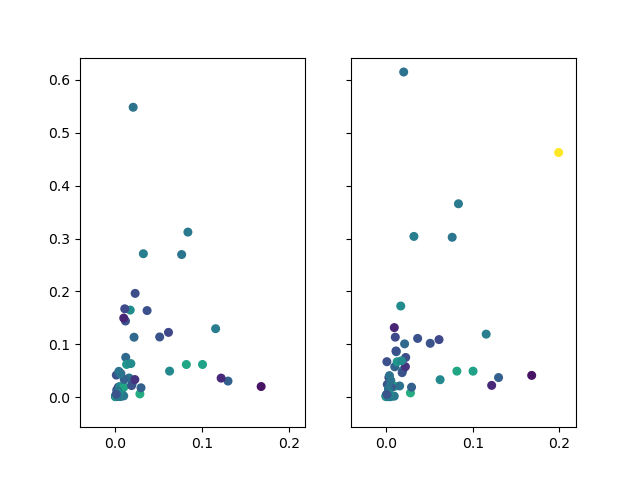

In [396]:
# Start with scatter, area concentration units
fig,axs=plt.subplots(1,2,sharex=True,sharey=True)


axs[0].scatter(dfA['part_per_m2_nofiber'],dfA['C_model'],30,
               dfA['area_m2'])
axs[1].scatter(dfB['part_per_m2_nofiber'],dfB['C_model'],30,
               dfB['area_m2'])

<IPython.core.display.Javascript object>


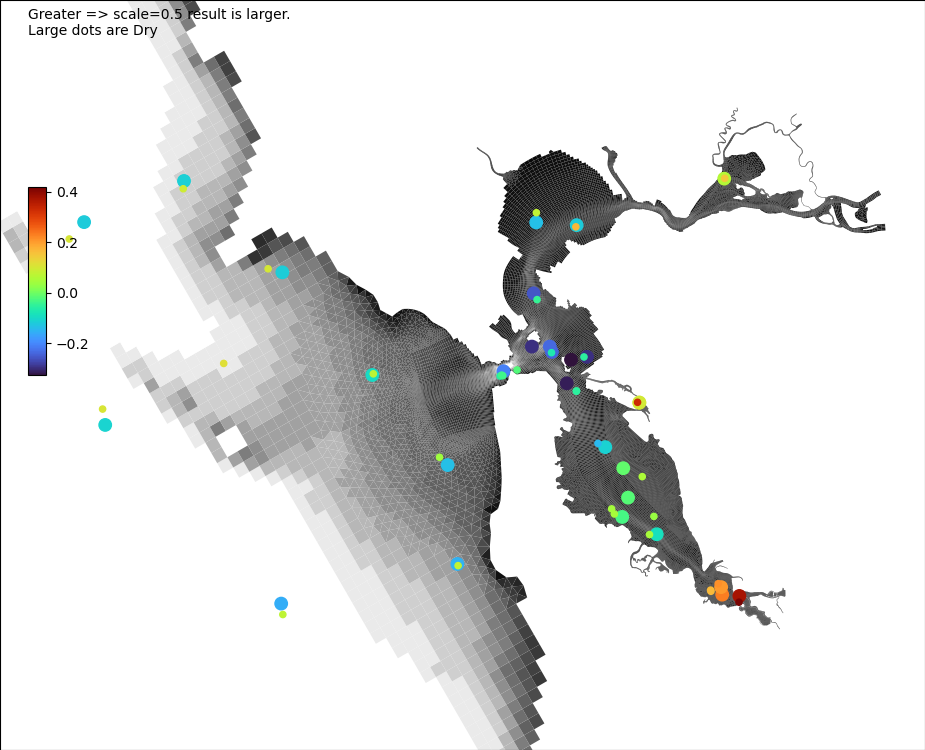

(335896.809213, 622757.585107, 3970068.9481499996, 4307931.05185)

In [416]:
fig=plt.figure(figsize=(9.25,7.5))
ax=fig.add_axes([0,0,1,1])

grid.plot_cells(values=grid.cells['cell_depth'],cmap='gray',clim=[0,100])

kws=dict(cmap='turbo',clim=[-3,1])
sel=dfA['Season']=='Dry'
scat=ax.scatter(dfA['x'],
                dfA['y'],
                20+60*sel,
                np.log10(dfA['C_model']/dfB['C_model']),**kws)
ax.text(0.03,0.99,"Greater => scale=0.5 result is larger.\nLarge dots are Dry",transform=ax.transAxes,va='top')
cax=fig.add_axes([0.03,0.5,0.02,0.25])
plt.colorbar(scat,cax=cax)

ax.axis('equal')

# so the coastal ocean ones are a mix, and maybe there is an issue with seasons?
# Dry season values are smaller in the scale=0.5 case.
# Wet season predictions are greater when scale=0.5, low beaching.
# So beaching is more relevant for coast samples in the wet season.
# maybe storm water samples are more prone to beaching, and are more
# relevant in the wet season.


# Some LSB samples are much greater when scale is small, because that forces beaching
# to be small and they probably are getting beached a lot down there.
# The rest of south bay is a wash.
# Central Bay has some samples that are much smaller when scale is 0.5, since
# these have relatively low beaching,being far from shore and in deep water.

# so what we're seeing is basically a seasonal pattern (beaching preferentially
# reduces wet season concentration), and a spatial pattern (beaching preferentially
# reduces LSB and maybe Suisun, and Central Bay is unaffected by beaching)



In [415]:
dfA['Season'].unique()

array(['Dry', 'Wet'], dtype=object)

In [403]:
grid.cells.dtype

dtype([('edges', '<i4', (4,)), ('nodes', '<i4', (4,)), ('_center', '<f8', (2,)), ('mark', '<i4'), ('_area', '<f8'), ('deleted', '?'), ('cell_depth', '<f8'), ('Mesh2_face_edges', '<i4', (4,)), ('Mesh2_face_depth', '<f8'), ('Mesh2_face_bc', '<i4'), ('z_bed', '<f8')])